In [1]:
import torch_geometric.utils
def agglomerative_clustering():


IndentationError: expected an indented block (2904659036.py, line 3)

In [136]:
entropy_layer = explain.nn.EntropyLinear(8, 1, n_classes=6)
entropy_layer(torch.randn((16, 8))).shape

torch.Size([16, 6, 1])

In [9]:
torch.rand(())

tensor(0.7158)

44


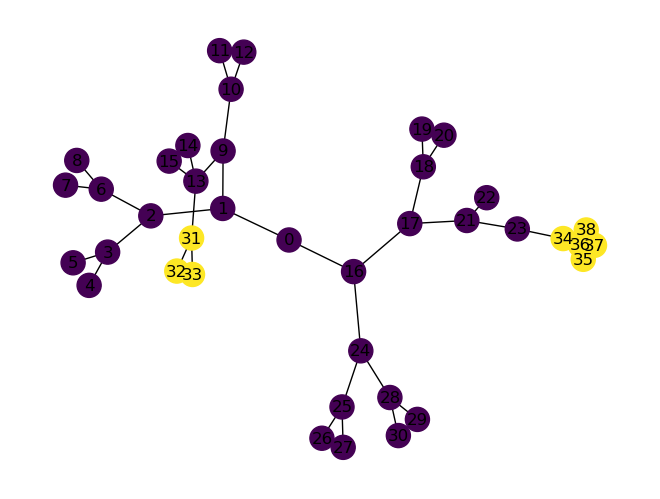

In [72]:
MAX_TREE_DEPTH = 4#5
MAX_NODES = (2 ** (MAX_TREE_DEPTH + 1) - 1) + 3 + 5 + 5
print(MAX_NODES)
def generate_custom_graph() -> Data:
    x, edge_index = generate_binary_tree(MAX_TREE_DEPTH, random=False)
    num_nodes_orig = x.shape[0]
    triangle = torch.randint(2, (1,))
    house = torch.randint(2, (1,))
    pentagon = torch.randint(2, (1,))
    y = triangle + 2 * house + 4 * pentagon
    #print(triangle, house, pentagon, y, num_nodes_orig)
    if triangle == 1:
        x_tri, ei_tri = generate_triangle(1)
        connector = torch.randint(num_nodes_orig, ())
        x, edge_index = merge_graphs(x, edge_index, x_tri, ei_tri)
        edge_index = torch.cat((edge_index, torch.tensor([[connector, num_nodes_orig], [num_nodes_orig, connector]], dtype=torch.long).T), dim=1)
    if house == 1:
        x_house, ei_house = generate_house(1, 1)
        connector = torch.randint(num_nodes_orig, ())
        num_nodes_prev = x.shape[0]
        x, edge_index = merge_graphs(x, edge_index, x_house, ei_house)
        edge_index = torch.cat((edge_index, torch.tensor([[connector, num_nodes_prev], [num_nodes_prev, connector]], dtype=torch.long).T), dim=1)
    if pentagon == 1:
        x_pent, ei_pent = generate_fully_connected(5, 1)
        connector = torch.randint(num_nodes_orig, ())
        num_nodes_prev = x.shape[0]
        x, edge_index = merge_graphs(x, edge_index, x_pent, ei_pent)
        edge_index = torch.cat((edge_index, torch.tensor([[connector, num_nodes_prev], [num_nodes_prev, connector]], dtype=torch.long).T), dim=1)

    return Data(x=x, y=y, edge_index=edge_index)#, adj=to_dense_adj(edge_index, max_num_nodes=MAX_NODES))

draw_graph(generate_custom_graph())

transform = transforms.ToDense(MAX_NODES)
train_data = [transform(generate_custom_graph()) for _ in range(512)]
test_data = [transform(generate_custom_graph()) for _ in range(128)]
num_classes = 8
num_node_features = NUM_COLORS

28


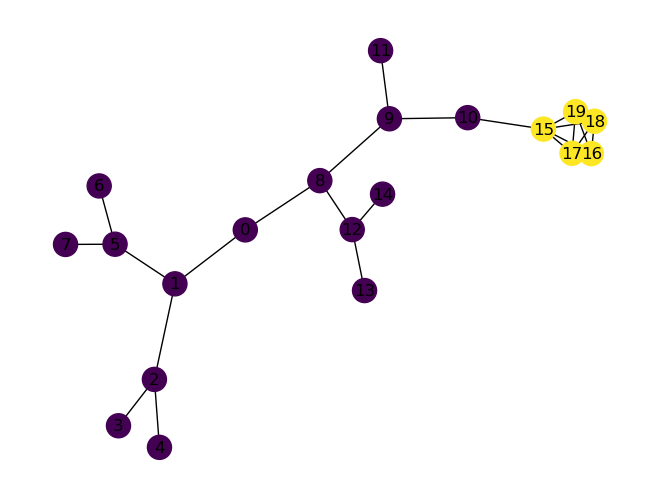

In [25]:
MAX_TREE_DEPTH = 3
MAX_NODES = (2 ** (MAX_TREE_DEPTH + 1) - 1) + 3 + 5 + 5
print(MAX_NODES)
def generate_custom_graph() -> Data:
    x, edge_index = generate_binary_tree(MAX_TREE_DEPTH, random=False)
    num_nodes_orig = x.shape[0]
    house = torch.randint(2, (1,))
    y = house
    if house == 1:
        x_house, ei_house = generate_house(1, 1)
        connector = torch.randint(num_nodes_orig, ())
        num_nodes_prev = x.shape[0]
        x, edge_index = merge_graphs(x, edge_index, x_house, ei_house)
        edge_index = torch.cat((edge_index, torch.tensor([[connector, num_nodes_prev], [num_nodes_prev, connector]], dtype=torch.long).T), dim=1)
    else:
        x_pent, ei_pent = generate_fully_connected(5, 1)
        connector = torch.randint(num_nodes_orig, ())
        num_nodes_prev = x.shape[0]
        x, edge_index = merge_graphs(x, edge_index, x_pent, ei_pent)
        edge_index = torch.cat((edge_index, torch.tensor([[connector, num_nodes_prev], [num_nodes_prev, connector]], dtype=torch.long).T), dim=1)

    return Data(x=x, y=y, edge_index=edge_index)#, adj=to_dense_adj(edge_index, max_num_nodes=MAX_NODES))

draw_graph(generate_custom_graph())

transform = transforms.ToDense(MAX_NODES)
train_data = [transform(generate_custom_graph()) for _ in range(512)]
test_data = [transform(generate_custom_graph()) for _ in range(128)]
num_classes = 2
num_node_features = NUM_COLORS

In [6]:
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.loader import DenseDataLoader
from torch_geometric import transforms

# Only 1 graph -> needs train/test/validation masks
# dataset = Planetoid(root='/tmp/Cora', name='Cora')

# multiple graphs -> just split them in train/test/val
# classification -> needs final pooling layer
# dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')

MAX_NODES = 150
class LimitNodesFilter(object):
    def __call__(self, data):
        return data.num_nodes <= MAX_NODES

#Limiting nodes required for DenseDataLoader
dataset = TUDataset(root='/tmp/PROTEINS', name='PROTEINS',
                    transform=transforms.ToDense(MAX_NODES),
                    pre_filter=LimitNodesFilter())

print(sum([d.num_nodes for d in dataset]))
print(dataset)
print(dataset[0])
print(dataset.num_classes)

dataset = dataset.shuffle()
train_percentage = 0.8
test_percentage = 0.2
valid_percentage = 0.0
test_start = int(train_percentage * len(dataset))
valid_start = int((train_percentage + test_percentage) * len(dataset))
train_data = dataset[:test_start - 1]
test_data = dataset[test_start:valid_start - 1]
print(train_data[0].adj)
num_classes = dataset.num_classes
num_node_features = dataset.num_node_features
#valid_data = dataset[valid_start:]

Extracting /tmp/PROTEINS/PROTEINS/PROTEINS.zip
Processing...
Done!


162750
PROTEINS(1085)
Data(x=[150, 3], y=[1], adj=[150, 150], mask=[150])
2
tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [83]:
from tqdm.notebook import tqdm
import wandb
from torch_geometric.loader import DenseDataLoader

device = torch.device('cuda')
wandb_run = None
wandb_run = wandb.init(project="MPhil-project", entity="jonas-juerss")
def log(*args, **kwargs):
    if wandb_run is not None:
        wandb.log(*args, **kwargs)

model = CustomNet(num_node_features, num_classes, layer_sizes=[[16, 16, 16, 16, 16], [16, 16, 16]],
                 num_nodes_per_layer=[5, 1], use_entropy_layer=False, conv_type=DenseGCNConv).to(device)
train_loader = DenseDataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DenseDataLoader(test_data, batch_size=64, shuffle=True)
#val_loader = DenseDataLoader(valid_data, batch_size=64, shuffle=True)
#print(train_data, test_data, valid_data)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
pooling_loss_weight = 0.0
entropy_loss_weight = 0.0001


def train_epoch(optimizer, loader, epoch):
    model.train()
    sum_loss = 0
    sum_classification_loss = 0
    sum_pooling_loss = 0
    sum_entropy_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out, pooling_loss, _ = model(data)
        classification_loss = F.nll_loss(out, data.y.squeeze(1))
        entropy_loss = model.entropy_loss()
        loss = classification_loss + pooling_loss_weight * pooling_loss + entropy_loss_weight * entropy_loss

        batch_size = data.y.size(0)
        sum_loss += batch_size * float(loss)
        sum_classification_loss += batch_size * float(classification_loss)
        sum_pooling_loss += batch_size * float(pooling_loss)
        sum_entropy_loss += batch_size * float(entropy_loss)

        loss.backward()
        optimizer.step()
    dataset_len = len(loader.dataset)
    log({"train_loss": sum_loss / dataset_len, "train_pooling_loss": sum_pooling_loss / dataset_len, "train_entropy_loss": sum_entropy_loss / dataset_len, "train_classification_loss": sum_classification_loss / dataset_len}, step=epoch, commit=False)


@torch.no_grad()
def test_epoch(loader, epoch):
    model.eval()
    correct = 0
    sum_loss = 0
    sum_classification_loss = 0
    sum_pooling_loss = 0
    sum_entropy_loss = 0
    # print(len(loader.dataset))
    for data in loader:
        data = data.to(device)
        out, pooling_loss, _ = model(data)
        classification_loss = F.nll_loss(out, data.y.squeeze(1))
        entropy_loss = model.entropy_loss()
        loss = classification_loss + pooling_loss_weight * pooling_loss + entropy_loss_weight * entropy_loss

        batch_size = data.y.size(0)
        sum_loss += batch_size * float(loss)
        sum_classification_loss += batch_size * float(classification_loss)
        sum_pooling_loss += batch_size * float(pooling_loss)
        sum_entropy_loss += batch_size * float(entropy_loss)
        # print(out)
        # print(out.argmax(dim=1))
        # print(data.y)
        # print((out.argmax(dim=1) == data.y.squeeze(1)).sum())
        # print("b", int((out.argmax(dim=1) == data.y.squeeze(1)).sum()), batch_size)
        correct += int((out.argmax(dim=1) == data.y.squeeze(1)).sum())

    # print(correct, len(loader.dataset))
    dataset_len = len(loader.dataset)
    log({"test_loss": sum_loss / dataset_len, "test_pooling_loss": sum_pooling_loss / dataset_len, "test_entropy_loss": sum_entropy_loss / dataset_len, "test_classification_loss": sum_classification_loss / dataset_len, "test_accuracy": correct / dataset_len}, step=epoch)



try:
    for epoch in tqdm(range(100)):
        train_epoch(optimizer, train_loader, epoch)
        test_epoch(test_loader, epoch)
finally:
    if wandb_run is not None:
        wandb_run.finish()


# OBVIOUSLY SHADY BUT OTHERWISE VALID WOULD BE TOO SMALL:
#valid_data = dataset
# correct = 0
# for data in val_loader:
#     out, pooling_loss = model(data.to(device))
#     correct += (out.argmax(dim=1) == data.y).sum()
# samples = len(valid_data)
# acc = correct / samples
# print(f'Accuracy: {acc:.4f} ({correct} of {samples} correct), Pooling loss: {pooling_loss:.4f}')

  0%|          | 0/100 [00:00<?, ?it/s]

test_accuracy,▁▁▁▁▁▂▃▂▄▄▆▅▅▆▆▆▇▇▆▇▆▆▇▆████████████████
test_classification_loss,██▇▇▇▆▅▅▄▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_entropy_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,██▇▇▇▆▅▅▄▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_pooling_loss,█▂▅▄▃▆▇▇▇▇▇▆▆▅▅▄▄▄▄▄▄▄▃▃▃▂▁▁▁▁▂▂▂▂▂▂▂▂▂▂
train_classification_loss,█▇▇▇▆▆▅▅▄▄▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_entropy_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▇▇▆▆▅▅▄▄▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_pooling_loss,█▃▄▄▃▄▇▇▆▆▆▆▅▅▅▄▄▄▄▄▄▄▃▂▃▂▁▁▁▁▂▂▂▂▂▂▂▂▂▂
test_accuracy,1.0
test_classification_loss,0.00817


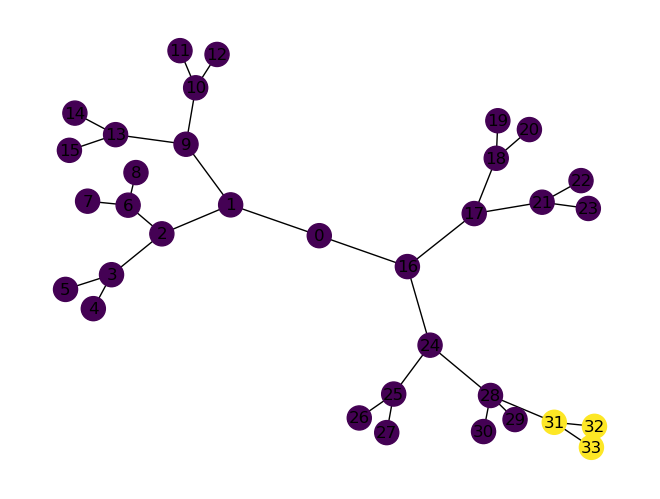

In [87]:
example = generate_custom_graph()
draw_graph(example)
example = transform(example)

In [88]:

def draw_diffpool_assignments(model : CustomNet, example : Data,
                              cluster_colors=[[1., 0, 0], [0, 1, 0], [0, 0, 1], [1, 1, 1], [0, 0, 0]]):
    cluster_colors = torch.tensor(cluster_colors)[None, :, :]
    out, _, pool_assignments = model(example.to(device)) # Do I need to add a batch dimension to the example?
    for assignment in pool_assignments[:1]:
        assignment = torch.softmax(assignment, dim=-1) # usually performed by diffpool function
        assignment = assignment.detach().cpu().squeeze(0) # remove batch dimensions
        if cluster_colors.shape[1] < assignment.shape[1]:
            raise ValueError(f"Only {cluster_colors.shape[1]} colors given to distinguish {assignment.shape[1]} cluster")
        example.edge_index = adj_to_edge_index(example.adj)
        g = torch_geometric.utils.to_networkx(example, to_undirected=True)
        # intermediate dimensions: num_nodes x num_clusters x 3
        colors = torch.sum(assignment[:, :, None] * cluster_colors[:, :assignment.shape[1], :], dim=1)
        nx.draw(g, node_color=colors, pos=nx.spring_layout(g, seed=1), with_labels=True)

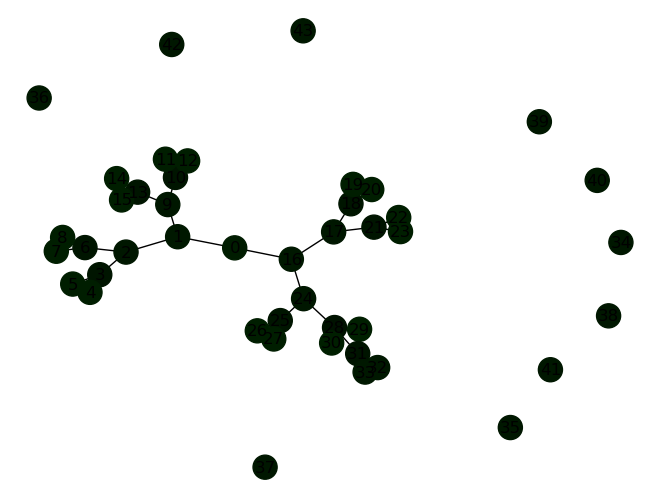

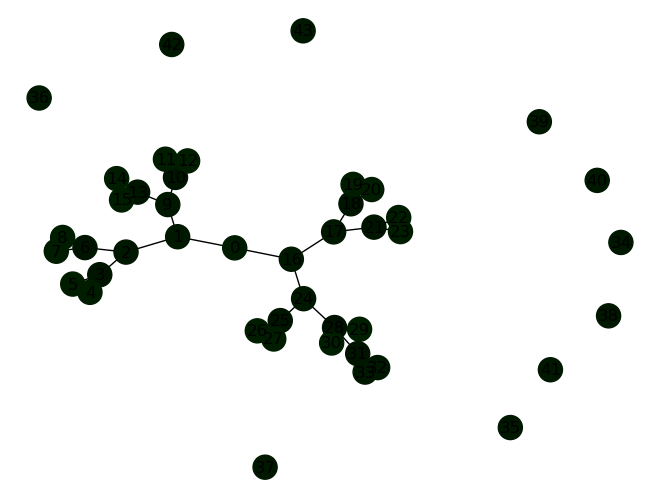

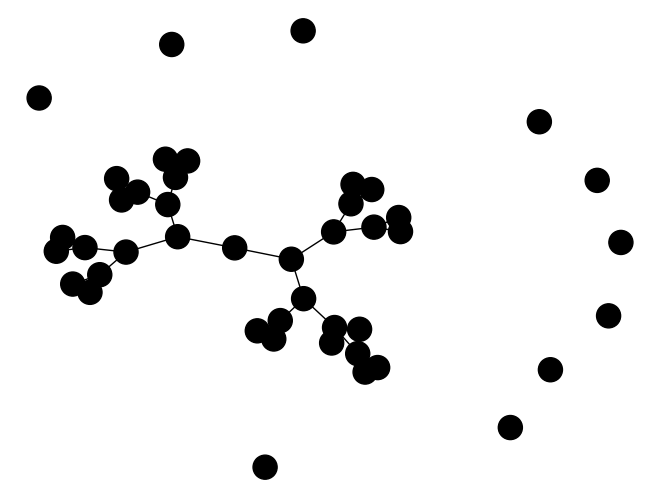

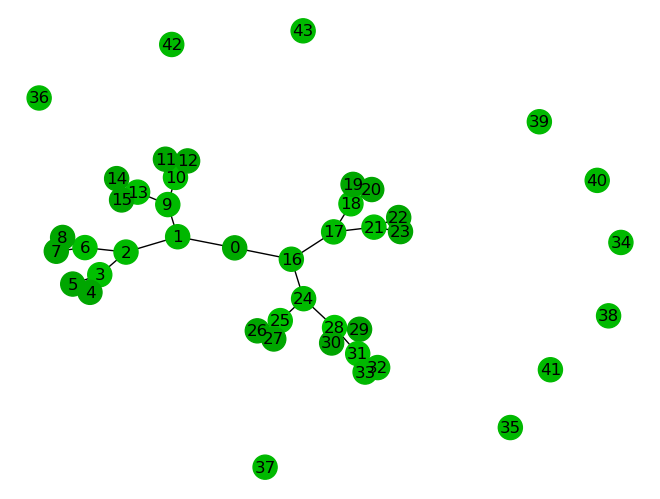

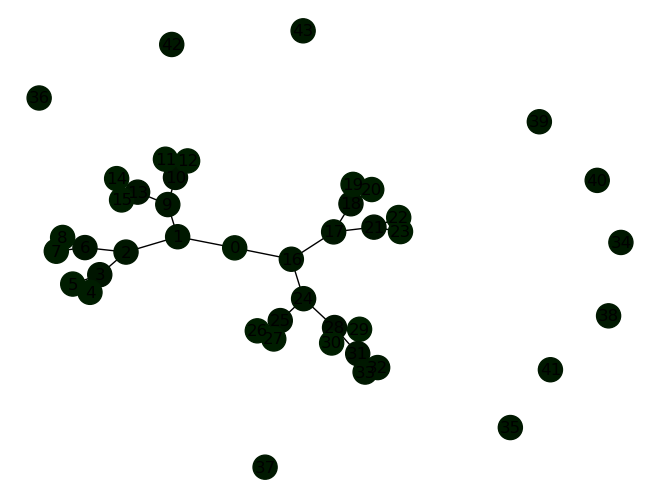

In [89]:
import matplotlib.pyplot as plt

num_clusters = 5
for i in range(num_clusters):
    cluster_colors=[[0., 0, 0] for _ in range(num_clusters)]
    cluster_colors[i] = [0, 1, 0]
    plt.figure(i)
    draw_diffpool_assignments(model, example, cluster_colors)

In [64]:
def distance_matrix(A):
    """
    :param A: n x m matrix with n >= m
    :return: A n x n matrix where res[i, j] is the euclidean distance between the ith and jth row vector of A
    """
    assert(A.shape[0] > A.shape[1])
    A = torch.arange(12).reshape(4, 3)
    n = A.shape[0]
    # a 2 x number of entries above the diagonal \approx roughly (n - 1)²/2 matrix
    i, j = torch.triu_indices(n, n, offset=1) # offset=1: only use pairs ABOVE (not on) the diagonal
    # [ONLY] for i < j distance between ith and jth vector is at distances[I would need to think about this]
    distances_temp = torch.sqrt(torch.sum((A[i, :] - A[j,:]) ** 2, dim=1))

    # This part is so we can just access A[i,j]=A[j,i] for any arbitrary distance. More convenient than having to calculate the index although additional overhead
    distances = torch.zeros((n, n))
    distances[i, j] = distances_temp
    return distances + distances.T

distance_matrix(torch.arange(12).reshape(4, 3))

tensor([[ 0.0000,  5.1962, 10.3923, 15.5885],
        [ 5.1962,  0.0000,  5.1962, 10.3923],
        [10.3923,  5.1962,  0.0000,  5.1962],
        [15.5885, 10.3923,  5.1962,  0.0000]])

In [38]:
from tqdm import tqdm

model = GCN(dataset).to(device)
data = dataset[0].to(device)
print(data)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in tqdm(range(10000)):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    if wandb_run is not None:
        log({"loss": loss})
    loss.backward()
    optimizer.step()

if wandb_run is not None:
    wandb_run.finish()

NameError: name 'GCN' is not defined

In [28]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.7710
